In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [2]:
from QuantumState import QCircuit

In [3]:
#Creation and normalization of an array with gaussian probabilities
def gauss(x, mu, sigma):
    dx = x[1]-x[0]
    g = (1/(np.sqrt(2*pi*sigma**2)))*np.exp(-((x-mu)**2)/(2*sigma**2))
    f = g*dx/(np.sum(g * dx))
    return f

In [4]:
#Loading of a probability distribution directly into the amplitudes 
#of the circuit
def ProbLoading(qubits, S, f):
    C = QCircuit(qubits+1)
    amplitudes = []
    amplitudes.append(0)
    for i in range(1, 2**qubits):
        site = np.log2(i)
        if site.is_integer()==True:
            amplitudes.append(np.sqrt(f[int(site)]))
        else:
            amplitudes.append(0)
    for i in range((2**(qubits+1)-(2**qubits))):
        amplitudes.append(0)
    C.psi = amplitudes
    return C

In [5]:
#Variational circuit that simulates a quantum random walk of a particle
def RWcircuit(qubits, parameters):
    if qubits%2==0: raise ValueError('Try odd number of qubits')
    C = QCircuit(qubits+1)
    mid = int((qubits-1)/2)
    C.X(mid)
    p = 0
    for layer in range(mid):
        #Population distribution to open states
        C.CU3(mid-layer, mid-layer-1, [parameters[p], 0, 0])
        p += 1
        C.Cx(mid-layer-1, mid-layer)
        C.CU3(mid+layer, mid+layer+1, [parameters[p], 0, 0])
        p += 1
        C.Cx(mid+layer+1, mid+layer)
        for i in reversed(range(layer)):
            #Probabilistic SWAPs for already occupied states
            C.Cx(mid-i, mid-i-1)
            C.CU3(mid-i-1, mid-i, [parameters[p], 0, 0])
            p += 1
            C.Cx(mid-i, mid-i-1)
            
            C.Cx(mid+i, mid+i+1)
            C.CU3(mid+i+1, mid+i, [parameters[p], 0, 0])
            p += 1
            C.Cx(mid+i, mid+i+1)
    return C
    

In [6]:
#Parameter creation for the first step of the variational algorithm
def parameters(qubits):
    a = int((qubits**2 - 2 * qubits + 1)/2)
    p = 2*pi*np.random.random((a,))
    return p

In [7]:
#Cost funtion 
def cost_function(par, qubits, ga):
    circ = RWcircuit(qubits, par)
    cost = 0
    psi = circ.psi
    for i in range(qubits):
        cost+=((ga[i]) - (np.abs(psi[int(2**i)]))**2)**2
    return cost

In [8]:
#Probability distribution of the circuit's final state
def result(par, qubits):
    circ = RWcircuit(qubits, par)
    psi = circ.psi
    sol = []
    for i in range(qubits):
        sol.append(np.abs(psi[int(2**i)])**2)
    return np.array(sol)

In [9]:
#Circuit that encodes the pay-off on the ancilla qubit (MSQ)
def PayoffCircuit(qubits, C, K, S):
    for i in range(qubits):
        bK = i
        if K<S[i]:
            break
    #Control-RY rotations controled by states with higher value than strike
    #targeting the ancilla qubit
    for i in range(bK, qubits):
        angle = 2 * np.arcsin(np.sqrt((S[i]-K)/S[qubits-1]))
        C.CU3(i, qubits, [angle, 0, 0])
    return C

In [10]:
#Classical algorithm to compare the pay-off from a precise gaussian to the quantum result
def Payoff(qubits, K, mu, sigma, C, S):
    psi = C.psi
    CPayoff = 0
    Sp = np.linspace(mu-3*sigma, mu+3*sigma, 2**qubits)
    fp = gauss(Sp, mu, sigma)
    for i in range(2**qubits):
        if K<Sp[i]:
            CPayoff += fp[i]*(Sp[i]-K)
    #The quantum pay-off is computes adding the probabilities 
    #of finding the ancilla qubit on the state 1
    QPayoff = 0
    for i in range(2**qubits, 2**(qubits+1)):
        QPayoff += S[qubits-1]*(np.abs(psi[i])**2)
    return CPayoff, QPayoff

In [11]:
from scipy.optimize import minimize

In [12]:
#Minimization methods
'''
'CG'
'BFGS' -> best but slow
'L-BFGS-B'
'SLSQP'
'''

"\n'CG'\n'BFGS' -> best but slow\n'L-BFGS-B'\n'SLSQP'\n"

In [54]:
#Initialize variables used in the computation
qu = 7
S0 = 100
K = 125
sig = 20

S = np.linspace(S0-3*sig, S0+3*sig, qu)
g = gauss(S, S0, sig)
para = parameters(qu)

In [55]:
cost = cost_function(para, qu, g)
print(cost)

0.24486646198065742


In [56]:
#Find and record the optimal parameters for the gaussian
solution = minimize(cost_function, para, args=(qu, g), method='BFGS', options={'disp': True})
optimal_parameters = solution.x

In [57]:
cost = cost_function(optimal_parameters, qu, g)
print(cost)

2.230728141281771e-05


In [58]:
#Calculate the final probabilities using the optimized parameters
r = result(optimal_parameters, qu)

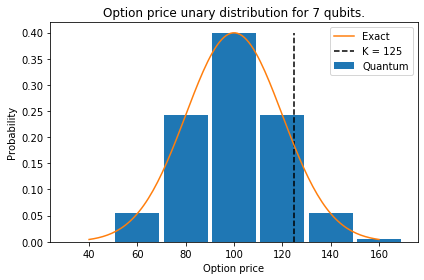

In [59]:
#Plot the probabilities of the circuit against the classical gaussian probabilities
width = (S[1]-S[0])/1.1
Sp = np.linspace(S0-3*sig, S0+3*sig, 2**qu)
fp = gauss(Sp, S0, sig)
fig, ax = plt.subplots()
#rects1 = ax.bar(S-width/2, g, width, label='Exact')
rects2 = ax.bar(S, r, width, label='Quantum')
ax.plot(Sp, max(r)*fp/max(fp), 'C1', label='Exact')

ax.vlines(K, 0, max(r), linestyles='dashed', label='K = {}'.format(K))
plt.ylabel('Probability')
plt.xlabel('Option price')
plt.title('Option price unary distribution for {} qubits.'.format(qu))
ax.legend()


fig.tight_layout()

#savefig('{}qubits_Comparision.png'.format(qu), bbox_inches='tight')

plt.show()

In [17]:
#Run the optmized circuit with the pay-off circuit
C = RWcircuit(qu, optimal_parameters)
C = PayoffCircuit(qu, C, K, S)

In [18]:
#Compute the classical precise pay-off and compare it with the one found quantically
CP, QP = Payoff(qu, K, S0, sig, C, S)

print('With precision {}'.format(2**qu))
print('Classical Pay-off: {}'.format(CP))
print('')
print('With precision {} qubits'.format(qu))
print('Quantum Pay-off: {}'.format(QP))
print('')
print('Percentage off: {}%'.format(np.abs(100*(CP-QP)*2/(CP + QP))))

With precision 128
Classical Pay-off: 0.9623295819223967

With precision 7 qubits
Quantum Pay-off: 0.9653205264333125

Percentage off: 0.3103202700480777%
